# **Proyecto Inteligencia Artificial con Aplicaciones en Economía I**

- **Hecho Por:** Carlos Jimenez / Fabian Yepes
- **Universidad:** Universidad Externado de Colombia

##**Predicción de insolvencia de las 10,000 empresas colombianas más importantes**

###1) Importación De Datos

In [40]:
# Cargar Librerias
!pip install kmodes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import train_test_split
# Mostrar todas las columnas
pd.options.display.max_columns = None
# En los dataframes, mostrar los float con dos decimales
pd.options.display.float_format = '{:,.3f}'.format

# Importar Bases de Datos
from google.colab import files
uploaded = files.upload()

Saving Base 9000_empresas_2025 Periodista.xlsx to Base 9000_empresas_2025 Periodista (1).xlsx
Saving Base 1000_empresas_2025.xlsx to Base 1000_empresas_2025 (1).xlsx


### 2) Preparación y Limpieza de Datos

In [41]:
df_1000_empresas = pd.read_excel('Base 1000_empresas_2025.xlsx', skiprows=4)
df_9000_empresas = pd.read_excel('Base 9000_empresas_2025 Periodista.xlsx', skiprows=4)
#Renombrar Columnas
df_1000_empresas = df_1000_empresas.rename(columns={'No.': 'RANKING', 'INGRESOS OPERACIONALES\n2024*': 'INGRESOS OPERACIONALES 2024', 'INGRESOS OPERACIONALES\n2023*': 'INGRESOS OPERACIONALES 2023'})
df_9000_empresas = df_9000_empresas.rename(columns={'INGRESOS OPERACIONALES 2024*': 'INGRESOS OPERACIONALES 2024', 'INGRESOS OPERACIONALES 2023*': 'INGRESOS OPERACIONALES 2023', 'Punto de entrada': 'GRUPO EN NIIF', 'DEPARTAMENTO DOMICILIO ': 'DEPARTAMENTO DOMICILIO'})

print(df_1000_empresas.columns)
print(df_9000_empresas.columns)
#Unir las Bases de Datos
df_empresas_2024 = pd.concat([df_1000_empresas, df_9000_empresas], axis = 0, ignore_index=True)

# Drop duplicate columns
df_empresas_2024 = df_empresas_2024.loc[:,~df_empresas_2024.columns.duplicated()]

# Verificar si hay valores faltantes
print(df_empresas_2024.isna().sum())

# Para rellenar valores faltantes se estima 2023 como 2024 descontando la inflación en Colombia
df_empresas_2024["INGRESOS OPERACIONALES 2023"] = df_empresas_2024["INGRESOS OPERACIONALES 2023"].fillna(df_empresas_2024["INGRESOS OPERACIONALES 2024"] / (1 + 0.0928))
df_empresas_2024["GANANCIA (PERDIDA) 2023"] = df_empresas_2024["GANANCIA (PERDIDA) 2023"].fillna(df_empresas_2024["GANANCIA (PERDIDA) 2024"] / (1 + 0.0928))
df_empresas_2024["TOTAL ACTIVOS 2023"] = df_empresas_2024["TOTAL ACTIVOS 2023"].fillna(df_empresas_2024["TOTAL ACTIVOS 2024"] / (1 + 0.0928))
df_empresas_2024["TOTAL PASIVOS 2023"] = df_empresas_2024["TOTAL PASIVOS 2023"].fillna(df_empresas_2024["TOTAL PASIVOS 2024"] / (1 + 0.0928))
df_empresas_2024["TOTAL PATRIMONIO 2023"] = df_empresas_2024["TOTAL PATRIMONIO 2023"].fillna(df_empresas_2024["TOTAL PATRIMONIO 2024"] / (1 + 0.0928))

# Eliminar variables irrelevantes
df_empresas_2024.drop(columns=["INGRESOS OPERACIONALES 2023", "GANANCIA (PERDIDA) 2023", "TOTAL ACTIVOS 2023", "TOTAL PASIVOS 2023", "TOTAL PATRIMONIO 2023"], inplace=True)
df_empresas_2024.dropna(inplace=True)

Index(['RANKING', 'NIT', 'RAZON SOCIAL', 'SUPERVISOR', 'REGION',
       'DEPARTAMENTO DOMICILIO', 'CIUDAD DOMICILIO', 'CIIU', 'MACROSECTOR',
       'INGRESOS OPERACIONALES 2024', 'GANANCIA (PERDIDA) 2024',
       'TOTAL ACTIVOS 2024', 'TOTAL PASIVOS 2024', 'TOTAL PATRIMONIO 2024',
       'INGRESOS OPERACIONALES 2023', 'GANANCIA (PERDIDA) 2023',
       'TOTAL ACTIVOS 2023', 'TOTAL PASIVOS 2023', 'TOTAL PATRIMONIO 2023',
       'GRUPO EN NIIF'],
      dtype='object')
Index(['RANKING', 'NIT', 'RAZON SOCIAL', 'SUPERVISOR', 'REGION',
       'DEPARTAMENTO DOMICILIO', 'CIUDAD DOMICILIO', 'CIIU', 'MACROSECTOR',
       'INGRESOS OPERACIONALES 2024', 'GANANCIA (PERDIDA) 2024',
       'TOTAL ACTIVOS 2024', 'TOTAL PASIVOS 2024', 'TOTAL PATRIMONIO 2024',
       'INGRESOS OPERACIONALES 2023', 'GANANCIA (PERDIDA) 2023',
       'TOTAL ACTIVOS 2023', 'TOTAL PASIVOS 2023', 'TOTAL PATRIMONIO 2023',
       'GRUPO EN NIIF'],
      dtype='object')
RANKING                        0
NIT                        

### 3) Creación Ratios Financieros

In [42]:
# Liquidez
df_empresas_2024['LIQUIDEZ_GENERAL'] = df_empresas_2024['TOTAL ACTIVOS 2024'] / df_empresas_2024['TOTAL PASIVOS 2024']

# Apalancamiento
df_empresas_2024['APALANCAMIENTO'] = df_empresas_2024['TOTAL PASIVOS 2024'] / df_empresas_2024['TOTAL ACTIVOS 2024']
df_empresas_2024['RAZON ENDEUDAMIENTO'] = df_empresas_2024['TOTAL PASIVOS 2024'] / df_empresas_2024['TOTAL PATRIMONIO 2024']

#Solidez
df_empresas_2024['AUTONOMIA FINANCIERA'] = df_empresas_2024['TOTAL PATRIMONIO 2024'] / df_empresas_2024['TOTAL ACTIVOS 2024']

# Rentabilidad
df_empresas_2024['ROA'] = df_empresas_2024['GANANCIA (PERDIDA) 2024'] / df_empresas_2024['TOTAL ACTIVOS 2024']
df_empresas_2024['ROE'] = df_empresas_2024['GANANCIA (PERDIDA) 2024'] / df_empresas_2024['TOTAL PATRIMONIO 2024']
df_empresas_2024['MARGEN_NETO'] = df_empresas_2024['GANANCIA (PERDIDA) 2024'] / df_empresas_2024['INGRESOS OPERACIONALES 2024']

# Eficiencia
df_empresas_2024['ROTACION_ACTIVOS'] = df_empresas_2024['INGRESOS OPERACIONALES 2024'] / df_empresas_2024['TOTAL ACTIVOS 2024']

## 4) Análisis Exploratorio de Datos

In [43]:
# Exploración Inicial Dataset
df_empresas_2024.shape
df_empresas_2024.drop(columns=['REGION', 'GRUPO EN NIIF'], inplace=True)
df_empresas_2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9993 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   RANKING                      9993 non-null   int64  
 1   NIT                          9993 non-null   int64  
 2   RAZON SOCIAL                 9993 non-null   object 
 3   SUPERVISOR                   9993 non-null   object 
 4   DEPARTAMENTO DOMICILIO       9993 non-null   object 
 5   CIUDAD DOMICILIO             9993 non-null   object 
 6   CIIU                         9993 non-null   object 
 7   MACROSECTOR                  9993 non-null   object 
 8   INGRESOS OPERACIONALES 2024  9993 non-null   float64
 9   GANANCIA (PERDIDA) 2024      9993 non-null   float64
 10  TOTAL ACTIVOS 2024           9993 non-null   float64
 11  TOTAL PASIVOS 2024           9993 non-null   float64
 12  TOTAL PATRIMONIO 2024        9993 non-null   float64
 13  LIQUIDEZ_GENERAL       

## Análisis de Variables No Numericas

### Variables Categoricas

In [44]:
# Analisis Variable DEPARTAMENTO DOMICILIO
df_empresas_2024['DEPARTAMENTO DOMICILIO'].unique()
departamentos = df_empresas_2024['DEPARTAMENTO DOMICILIO'].value_counts()
departamentos_porc = df_empresas_2024['DEPARTAMENTO DOMICILIO'].value_counts(normalize=True) * 100
dept_table = pd.DataFrame({'Empresas': departamentos, 'Porcentaje (%)': departamentos_porc.round(2)})
dept_table = dept_table.reset_index().rename(columns={'DEPARTAMENTO DOMICILIO': 'DEPARTAMENTO'})

# Tabla de Departaments
print("Top 10 Departamentos por Número de Empresas:\n")
print(dept_table.to_string(index=False))

Top 10 Departamentos por Número de Empresas:

            DEPARTAMENTO  Empresas  Porcentaje (%)
             BOGOTA D.C.      3982          39.850
               ANTIOQUIA      1850          18.510
                   VALLE       875           8.760
            CUNDINAMARCA       717           7.180
               ATLANTICO       536           5.360
               SANTANDER       366           3.660
                 BOLIVAR       240           2.400
               RISARALDA       171           1.710
      NORTE DE SANTANDER       161           1.610
                  CALDAS       128           1.280
                    META       113           1.130
               MAGDALENA       108           1.080
                  NARINO        87           0.870
                   HUILA        85           0.850
                  TOLIMA        79           0.790
                  BOYACA        68           0.680
                   CAUCA        68           0.680
                 CORDOBA        63  

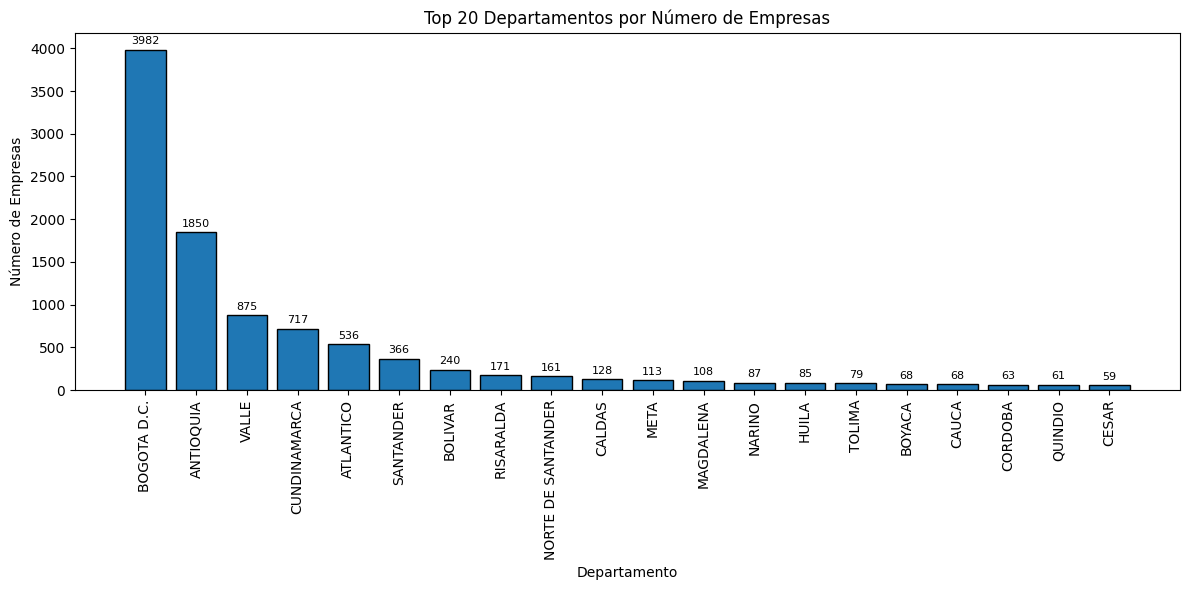

In [45]:
# Gráfico de barras
import matplotlib.pyplot as plt
departamentos_sorted = dept_table.sort_values(by='Empresas', ascending=False).head(20)
plt.figure(figsize=(12, 6))
plt.bar(departamentos_sorted['DEPARTAMENTO'], departamentos_sorted['Empresas'], edgecolor='black')
plt.xticks(rotation=90)

#Etiqueta de datos
plt.title("Top 20 Departamentos por Número de Empresas")
plt.ylabel("Número de Empresas")
plt.xlabel("Departamento")
for i, v in enumerate(departamentos_sorted['Empresas']):
    plt.text(i, v + max(departamentos_sorted['Empresas']) * 0.01, str(int(v)), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()



In [46]:
# Analisis Variable MACROSECTOR
df_empresas_2024['MACROSECTOR'].unique()
sectores = df_empresas_2024['MACROSECTOR'].value_counts()
sector_table = pd.DataFrame({'Empresas': sectores})
sector_table = sector_table.reset_index().rename(columns={'MACROSECTOR': 'Sector'})

# Tabla de Sectores
print("Distribución Empresarial por Sector:\n")
print(sector_table.to_string(index=False))

Distribución Empresarial por Sector:

              Sector  Empresas
            COMERCIO      3415
           SERVICIOS      3330
         MANUFACTURA      1918
        CONSTRUCCIÓN       755
        AGROPECUARIO       393
MINERO-HIDROCARBUROS       182


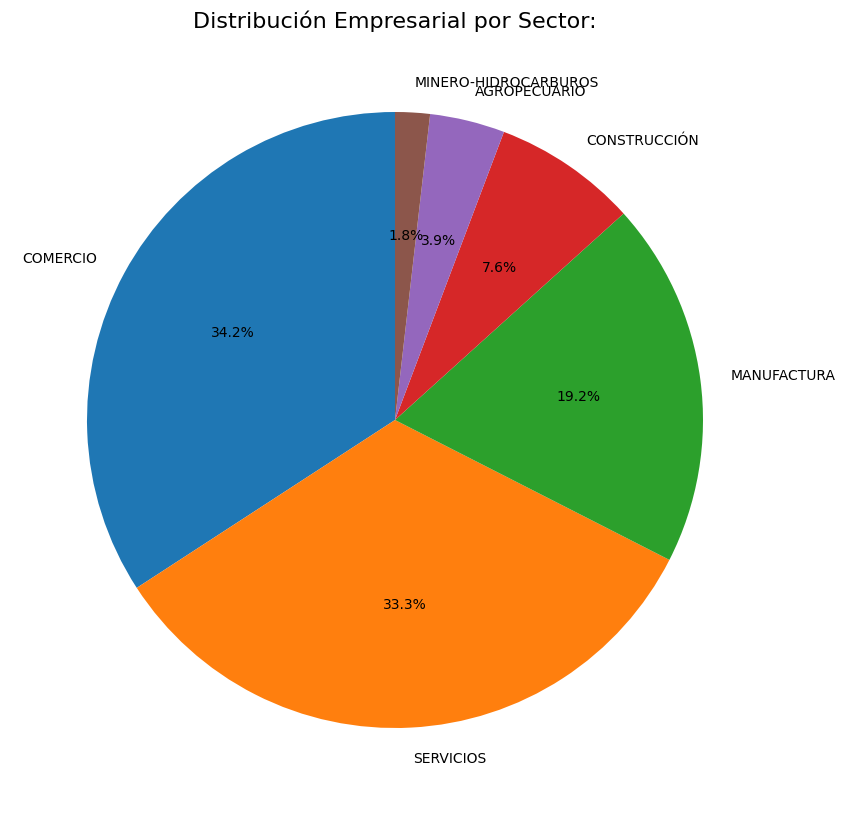

In [47]:
# Gráfico de torta
plt.figure(figsize=(10, 10))
plt.pie(sectores,
        labels=sectores.index,
        autopct='%1.1f%%', # Formato para mostrar porcentajes con un decimal
        startangle=90      # Inicia el primer 'trozo' en la parte superior
        )

plt.title('Distribución Empresarial por Sector:', fontsize=16)
plt.ylabel('') # Quitamos el label del eje y que matplotlib añade por defecto
plt.show()

## Análisis de Variables Numericas

In [48]:
# # Analisis SECTOR - INGRESO
sector_ingresos = df_empresas_2024.groupby('MACROSECTOR')['INGRESOS OPERACIONALES 2024'].sum().sort_values(ascending=False)
sector_ingresos_table = sector_ingresos.reset_index().rename(columns={'INGRESOS OPERACIONALES 2024': 'TOTAL INGRESOS 2024 (Miles COP)'})
sector_ingresos_table['PORCENTAJE (%)'] = (sector_ingresos_table['TOTAL INGRESOS 2024 (Miles COP)'] / sector_ingresos_table['TOTAL INGRESOS 2024 (Miles COP)'].sum()) * 100
sector_ingresos_table['PORCENTAJE (%)'] = sector_ingresos_table['PORCENTAJE (%)'].round(2)

print(sector_ingresos_table.to_string(index=False))

         MACROSECTOR  TOTAL INGRESOS 2024 (Miles COP)  PORCENTAJE (%)
            COMERCIO              566,874,749,831.891          32.120
           SERVICIOS              500,125,711,259.680          28.340
         MANUFACTURA              389,311,377,267.178          22.060
MINERO-HIDROCARBUROS              193,453,256,833.929          10.960
        CONSTRUCCIÓN               76,491,121,016.546           4.330
        AGROPECUARIO               38,353,798,039.000           2.170


In [49]:
# Analisis SECTOR - GANANCIAS
sector_ganancia = df_empresas_2024.groupby('MACROSECTOR')['GANANCIA (PERDIDA) 2024'].sum().sort_values(ascending=False)
sector_ganancia = sector_ganancia * 1000
ganancia_table = sector_ganancia.reset_index().rename(columns={'GANANCIA (PERDIDA) 2024': 'TOTAL GANANCIAS 2024 (COP)'})

#Abreviar Valores
def abbreviate_number(num):
    if num >= 1e12:
        return f"{num / 1e12:.1f}B"  # Billones
    elif num >= 1e9:
        return f"{num / 1e9:.1f}K MM"  # Miles de millones
    elif num >= 1e6:
        return f"{num / 1e6:.1f}M"  # Millones
    elif num >= 1e3:
        return f"{num / 1e3:.1f}K"  # Miles
    else:
        return str(int(num))

# Tabla de Ganancias por Sector
ganancia_table['GANANCIAS ABREVIADAS'] = ganancia_table['TOTAL GANANCIAS 2024 (COP)'].apply(abbreviate_number)
print("Ganancias Totales por Sector:\n")
print(ganancia_table.to_string(index=False))


Ganancias Totales por Sector:

         MACROSECTOR  TOTAL GANANCIAS 2024 (COP) GANANCIAS ABREVIADAS
           SERVICIOS      68,685,137,114,205.430                68.7B
MINERO-HIDROCARBUROS      18,444,480,304,168.000                18.4B
         MANUFACTURA      16,066,335,359,160.000                16.1B
            COMERCIO      11,992,685,360,206.000                12.0B
        CONSTRUCCIÓN       5,585,390,355,271.070                 5.6B
        AGROPECUARIO       1,828,635,672,000.000                 1.8B


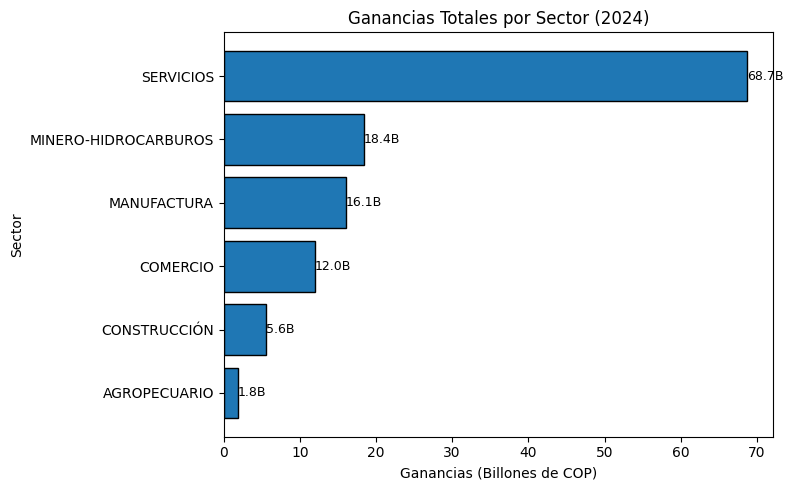

In [50]:
# Grafico de Barras Horizontal
ganancia_table['GANANCIAS_BILLONES'] = ganancia_table['TOTAL GANANCIAS 2024 (COP)'] / 1e12
ganancia_table = ganancia_table.sort_values(by='GANANCIAS_BILLONES', ascending=True)

plt.figure(figsize=(8,5))
bars = plt.barh(ganancia_table['MACROSECTOR'], ganancia_table['GANANCIAS_BILLONES'], edgecolor='black')
plt.xlabel("Ganancias (Billones de COP)")
plt.ylabel("Sector")
plt.title("Ganancias Totales por Sector (2024)")

#Etiquetas de datos
for bar, label in zip(bars, ganancia_table['GANANCIAS ABREVIADAS']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, label, va='center', fontsize=9)

plt.tight_layout()
plt.show()



In [51]:
# ANALISIS SECTOR - PASIVOS
sector_pasivos = df_empresas_2024.groupby('MACROSECTOR')['TOTAL PASIVOS 2024'].sum().sort_values(ascending=False)
sector_pasivos = sector_pasivos * 1000
pasivos_table = sector_pasivos.reset_index().rename(columns={'TOTAL PASIVOS 2024': 'TOTAL PASIVOS 2024 (COP)'})

# Abreviar valores
pasivos_table['PASIVOS ABREVIADOS'] = pasivos_table['TOTAL PASIVOS 2024 (COP)'].apply(abbreviate_number)

# Tabla de Pasivos por Sector
print("Pasivos Totales por Sector:\n")
print(pasivos_table.to_string(index=False))


Pasivos Totales por Sector:

         MACROSECTOR  TOTAL PASIVOS 2024 (COP) PASIVOS ABREVIADOS
           SERVICIOS   499,534,958,931,758.875             499.5B
            COMERCIO   206,671,374,305,751.000             206.7B
         MANUFACTURA   197,379,462,250,217.000             197.4B
MINERO-HIDROCARBUROS   191,416,172,571,547.000             191.4B
        CONSTRUCCIÓN   151,358,414,752,457.000             151.4B
        AGROPECUARIO    19,505,030,027,000.000              19.5B


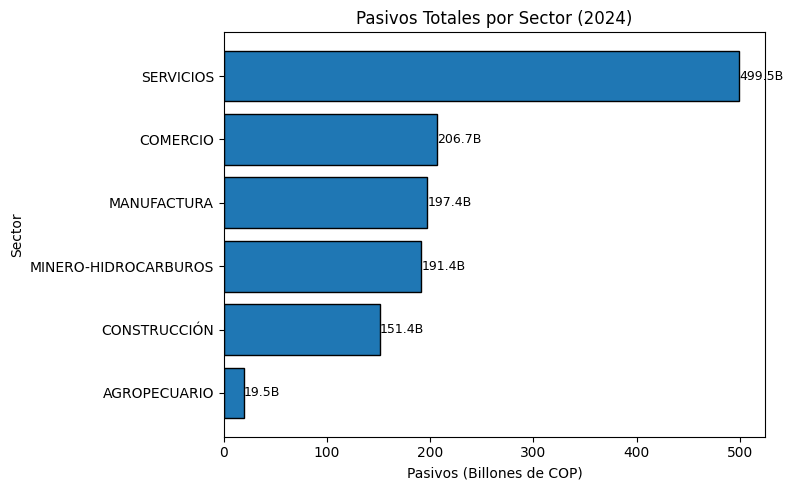

In [52]:
# Gráfico de Barras Horizontal
pasivos_table['PASIVOS_BILLONES'] = pasivos_table['TOTAL PASIVOS 2024 (COP)'] / 1e12
pasivos_table = pasivos_table.sort_values(by='PASIVOS_BILLONES', ascending=True)

plt.figure(figsize=(8,5))
bars = plt.barh(pasivos_table['MACROSECTOR'], pasivos_table['PASIVOS_BILLONES'], edgecolor='black')
plt.xlabel("Pasivos (Billones de COP)")
plt.ylabel("Sector")
plt.title("Pasivos Totales por Sector (2024)")

# Etiquetas de datos
for bar, label in zip(bars, pasivos_table['PASIVOS ABREVIADOS']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, label, va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [53]:
# Analisis Empresas con mayores pasivos
top_pasivos_empresas = df_empresas_2024[['RAZON SOCIAL', 'TOTAL PASIVOS 2024']].copy()
top_pasivos_empresas['TOTAL PASIVOS 2024'] = top_pasivos_empresas['TOTAL PASIVOS 2024'] * 1000

top20_pasivos = top_pasivos_empresas.sort_values(by='TOTAL PASIVOS 2024', ascending=False).head(20)
top20_pasivos['PASIVOS ABREVIADOS'] = top20_pasivos['TOTAL PASIVOS 2024'].apply(abbreviate_number)
top20_pasivos.rename(columns={'TOTAL PASIVOS 2024': 'TOTAL PASIVOS 2024 (COP)'}, inplace=True)

#Tabla Empresas con mas pasivos
print("Top 20 Empresas con Más Pasivos en 2024:\n")
print(top20_pasivos.to_string(index=False))


Top 20 Empresas con Más Pasivos en 2024:

                                                                       RAZON SOCIAL  TOTAL PASIVOS 2024 (COP) PASIVOS ABREVIADOS
                                                                      ECOPETROL S.A   130,544,063,451,000.000             130.5B
                                              EMPRESAS PÚBLICAS DE MEDELLÍN E.S.P.     34,455,520,000,000.000              34.5B
                                     AEROVIAS DEL CONTINENTE AMERICANO S.A. AVIANCA    23,203,285,004,000.000              23.2B
                                                                 ISAGEN S.A. E.S.P.    18,731,662,323,000.000              18.7B
                                                          COMUNICACIÓN CELULAR S.A.    16,951,909,575,000.000              17.0B
                                                                 EMGESA S.A. E.S.P.    14,463,972,245,000.000              14.5B
                                                       

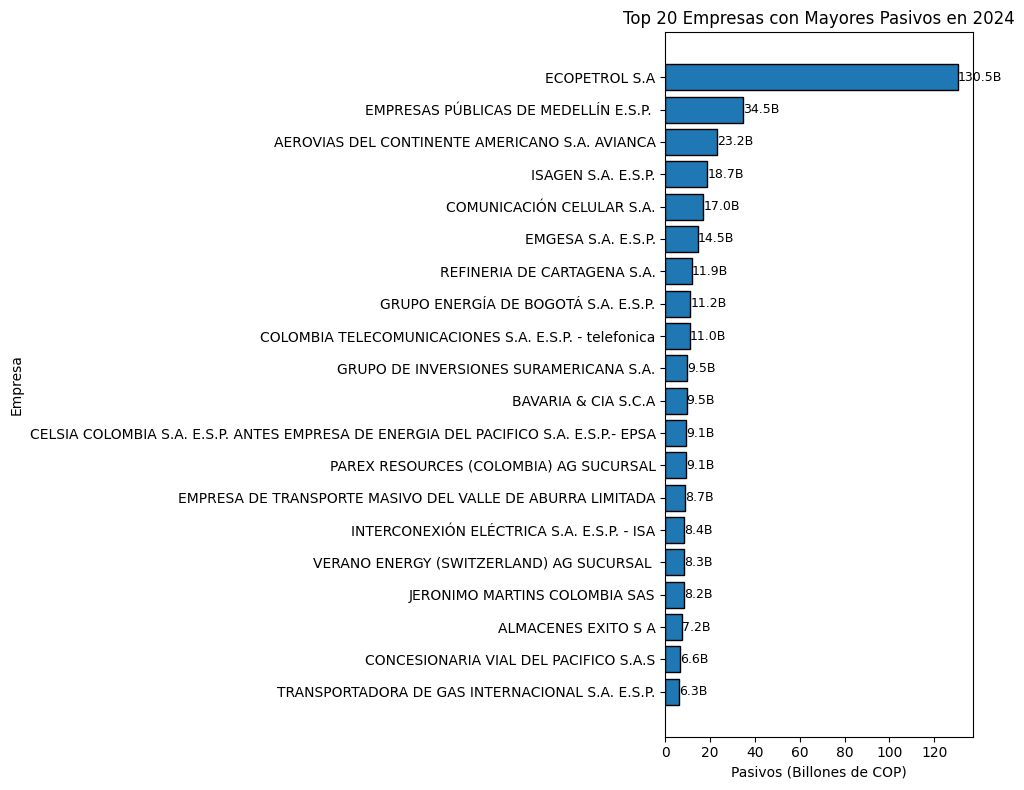

In [54]:
# Grafico de Barras
plt.figure(figsize=(10,8))
bars = plt.barh(top20_pasivos['RAZON SOCIAL'], top20_pasivos['TOTAL PASIVOS 2024 (COP)']/1e12, edgecolor='black')

plt.xlabel("Pasivos (Billones de COP)")
plt.ylabel("Empresa")
plt.title("Top 20 Empresas con Mayores Pasivos en 2024")

# Agregar etiquetas abreviadas
for bar, label in zip(bars, top20_pasivos['PASIVOS ABREVIADOS']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, label, va='center', fontsize=9)

plt.gca().invert_yaxis()  # Invertir el orden
plt.tight_layout()
plt.show()

## Analisis Ratios

### Analisis Ratios Especificos

In [55]:
# Analisis LIQUIDEZ
top_iliquidez = df_empresas_2024[["RANKING",'RAZON SOCIAL', "MACROSECTOR",'LIQUIDEZ_GENERAL']].copy()

top20_iliquidas = top_iliquidez.sort_values(by='LIQUIDEZ_GENERAL', ascending=True).head(20)
top20_iliquidas.rename(columns={'LIQUIDEZ_GENERAL': 'Ratio Liquidez', "MACROSECTOR" : "Sector", "RAZON SOCIAL": "Empresa"}, inplace=True)

print("Top 20 Empresas con peor Ratio de Liquidez:\n")
print(top20_iliquidas.to_string(index=False))

Top 20 Empresas con peor Ratio de Liquidez:

 RANKING                                                Empresa       Sector  Ratio Liquidez
    6075                                    COBB COLOMBIA S.A.S AGROPECUARIO           0.087
    2088                                    SPIRIT AIRLINES INC    SERVICIOS           0.172
    1167                                     V V TECHNOLOGY SAS     COMERCIO           0.189
    9333                                              CEETTV SA    SERVICIOS           0.198
    5548                         MEGATIENDAS SUPERMAYORISTA SAS     COMERCIO           0.226
    7822                     VERSILIA SOLUTIONS COLOMBIA S.A.S      COMERCIO           0.285
    8852                         SANULAC NUTRICION COLOMBIA SAS     COMERCIO           0.301
    8225                                TIMAC AGRO COLOMBIA SAS  MANUFACTURA           0.302
    6938                    RED ASSIST SAS - EN REORGANIZACION     SERVICIOS           0.320
    1058                 

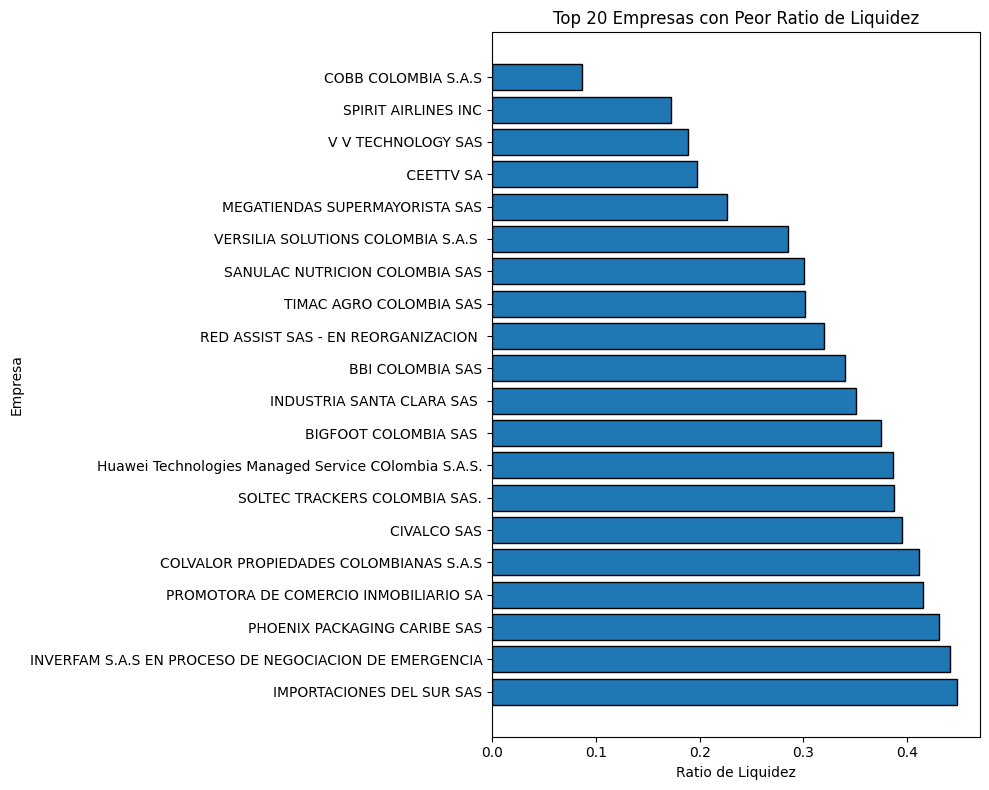

In [56]:
# Grafico de Barras
plt.figure(figsize=(10,8))
bars = plt.barh(top20_iliquidas['Empresa'], top20_iliquidas['Ratio Liquidez'], edgecolor='black')

plt.xlabel("Ratio de Liquidez")
plt.ylabel("Empresa")
plt.title("Top 20 Empresas con Peor Ratio de Liquidez")

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [57]:
# Analisis ROE
top_roe = df_empresas_2024[["RANKING",'RAZON SOCIAL', "MACROSECTOR",'ROE']].copy()

top20_roe = top_roe.sort_values(by='ROE', ascending=False).head(20)
top20_roe.rename(columns={'LIQUIDEZ_GENERAL': 'Ratio Liquidez', "MACROSECTOR" : "Sector", "RAZON SOCIAL": "Empresa"}, inplace=True)

print("Top 20 Empresas con Mayor ROE:\n")
print(top20_roe.to_string(index=False))

Top 20 Empresas con Mayor ROE:

 RANKING                                                    Empresa               Sector         ROE
     835                                        UNITED AIRLINES INC            SERVICIOS 154,861.324
    5282                                                TURFLOR SAS         AGROPECUARIO     207.620
    7669                                     INTERCARBON MINING SAS MINERO-HIDROCARBUROS     108.679
     494 Compañia de inversiones textiles de moda SAS - TEXMODA SAS             COMERCIO      43.971
     752                       MASIVO CAPITAL SAS EN REORGANIZACION            SERVICIOS      30.465
    1174                                  GLOBAL WINE & SPIRITS SAS             COMERCIO      24.031
    6540                                     GB BIOPACOL ANDINA SAS          MANUFACTURA      22.439
    5452                                       KUSHKI COLOMBIA S.A.            SERVICIOS      16.675
    3776                                               ELIT

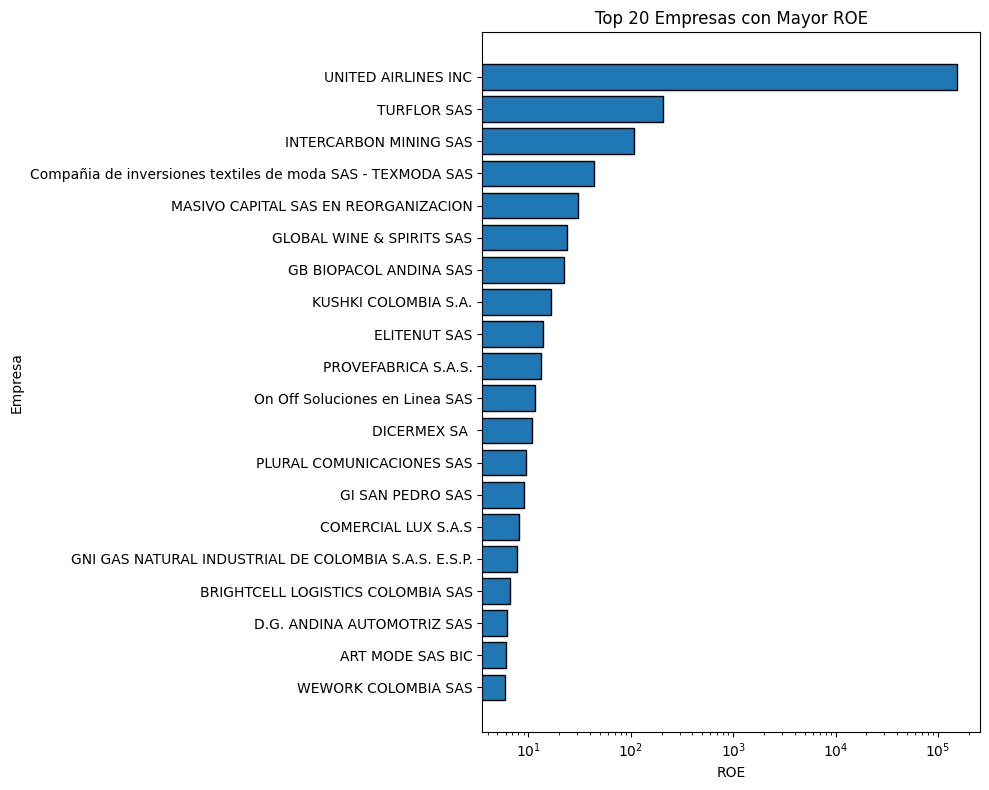

In [58]:
# Grafico de Barras
plt.figure(figsize=(10,8))
bars = plt.barh(top20_roe['Empresa'], top20_roe['ROE'], edgecolor='black')

plt.xlabel("ROE")
plt.xscale('log')
plt.ylabel("Empresa")
plt.title("Top 20 Empresas con Mayor ROE")

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

###Analisis En Conjunto

In [59]:
# Estadísticas descriptivas de los indicadores, encontramos valores extremos e infinitos en indicadores financieros dado patrimonios cercanos a cero,
# Pasivos en cero o ingresos atípicos, para solucionarlos hicimos lo siguiente:
# -Se reemplazaron divisiones por cero con NaN.
# -Se aplicó winsorización para hacer recorte en los percentiles 1% y 99%.
# Asi los indicadores representen mejor la distribución típica de las empresas.

df_empresas_2024.replace([np.inf, -np.inf], np.nan, inplace=True)

def winsorize(series, lower=0.01, upper=0.99):
    q_low, q_high = series.quantile([lower, upper])
    return series.clip(q_low, q_high)

for col in ['LIQUIDEZ_GENERAL', 'APALANCAMIENTO', 'RAZON ENDEUDAMIENTO',
            'AUTONOMIA FINANCIERA', 'ROA', 'ROE', 'MARGEN_NETO', 'ROTACION_ACTIVOS']:
    df_empresas_2024[col] = winsorize(df_empresas_2024[col])

indicadores = ['LIQUIDEZ_GENERAL', 'APALANCAMIENTO', 'RAZON ENDEUDAMIENTO',
               'AUTONOMIA FINANCIERA', 'ROA', 'ROE', 'MARGEN_NETO', 'ROTACION_ACTIVOS']
scaler = StandardScaler()
df_empresas_scaled = scaler.fit_transform(df_empresas_2024[indicadores].dropna())


df_empresas_2024[indicadores].describe().T



,count,mean,std,min,25%,50%,75%,max
LIQUIDEZ_GENERAL,"9,992.000",3.214,6.652,0.813,1.410,1.825,2.699,59.956
APALANCAMIENTO,"9,993.000",0.544,0.243,0.016,0.371,0.548,0.709,1.230
RAZON ENDEUDAMIENTO,"9,993.000",2.169,4.708,-10.385,0.540,1.135,2.259,33.746
AUTONOMIA FINANCIERA,"9,993.000",0.456,0.243,-0.230,0.291,0.452,0.629,0.984
ROA,"9,993.000",0.061,0.097,-0.288,0.014,0.049,0.101,0.421
ROE,"9,993.000",0.141,0.308,-1.358,0.043,0.120,0.225,1.430
MARGEN_NETO,"9,993.000",0.062,0.159,-0.369,0.008,0.032,0.075,0.970
ROTACION_ACTIVOS,"9,993.000",1.932,2.002,0.074,0.862,1.384,2.242,13.728


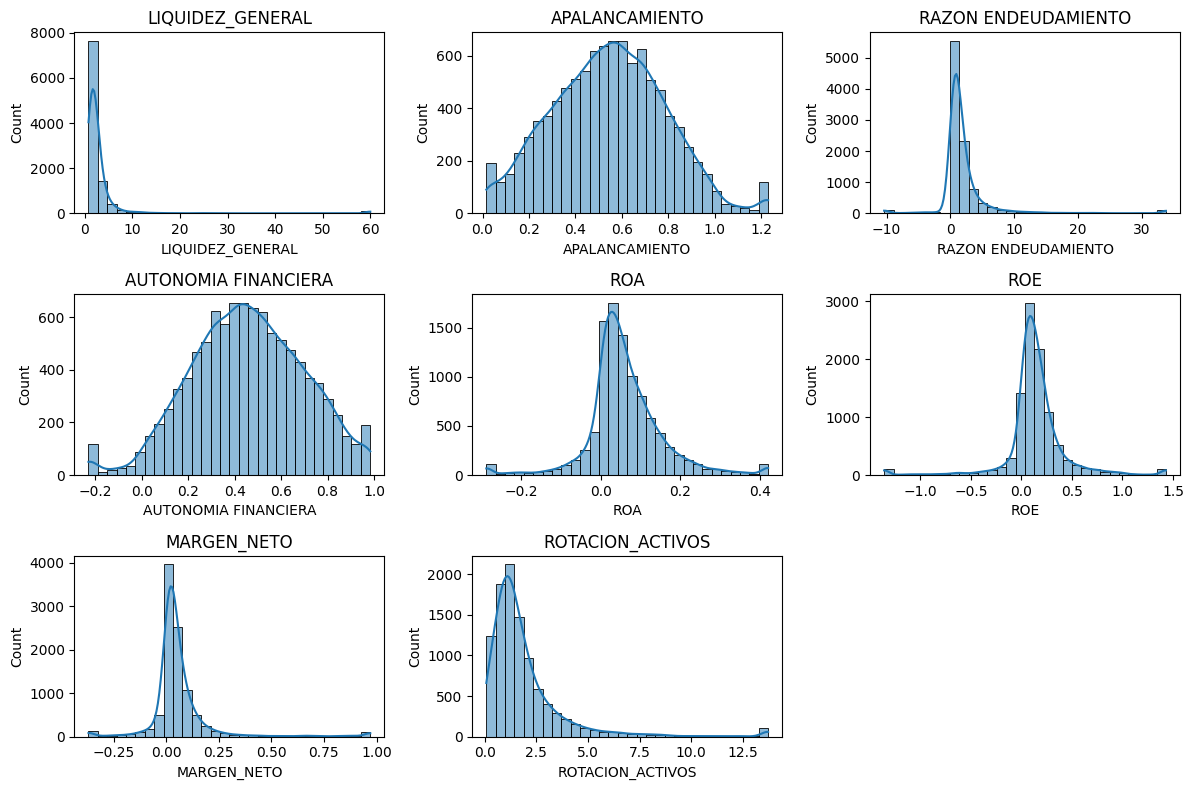

In [60]:
#Analisis Distribución Ratios
plt.figure(figsize=(12,8))
for i, col in enumerate(indicadores, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_empresas_2024[col].dropna(), kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

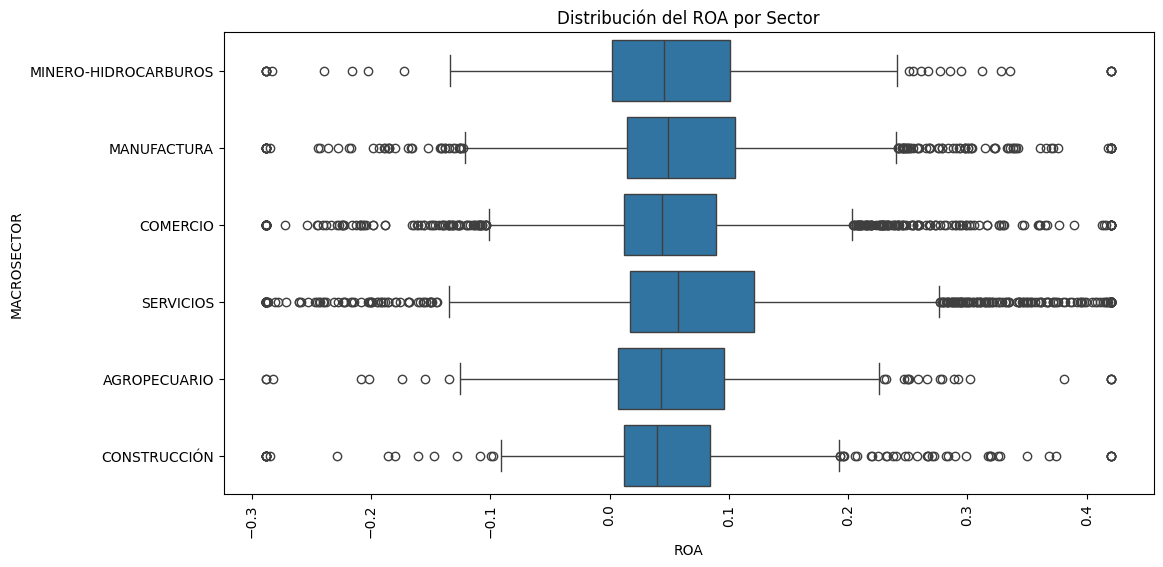

In [61]:
#Diagrama de Caja y Bigotes ROA-SECTOR
plt.figure(figsize=(12,6))
sns.boxplot(data=df_empresas_2024, x="ROA", y="MACROSECTOR")
plt.xticks(rotation=90)
plt.title("Distribución del ROA por Sector")
plt.show()

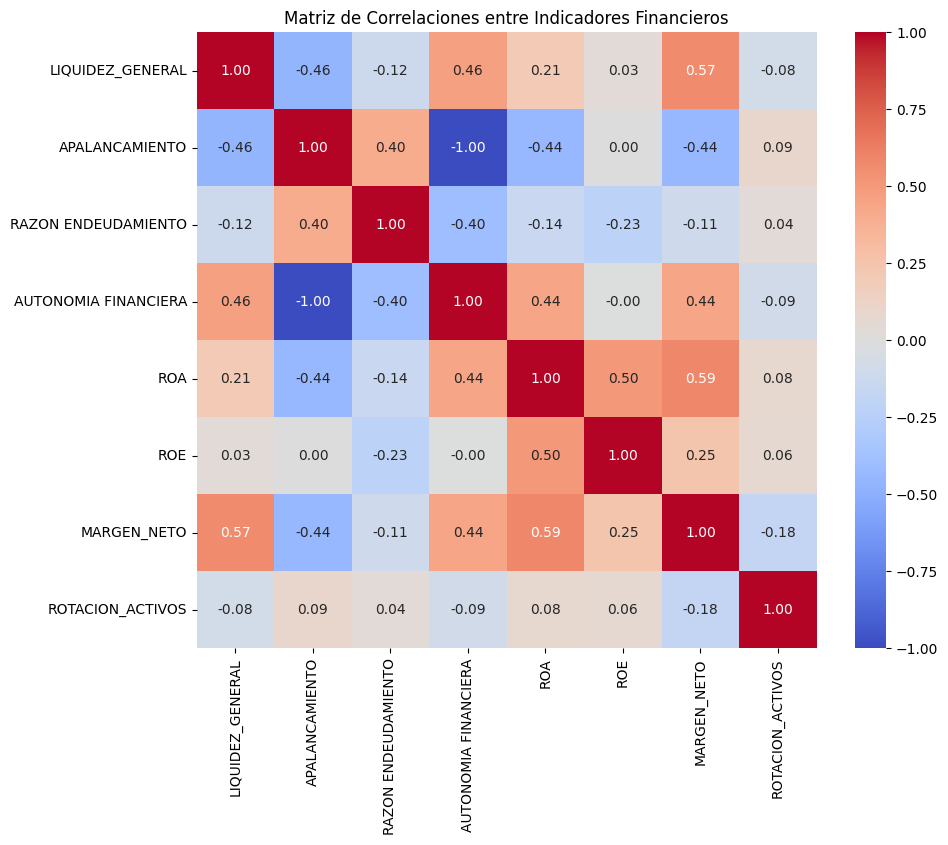

In [62]:
#Analisis Correlación Ratios
plt.figure(figsize=(10,8))
sns.heatmap(df_empresas_2024[indicadores].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlaciones entre Indicadores Financieros")
plt.show()

### Outliers

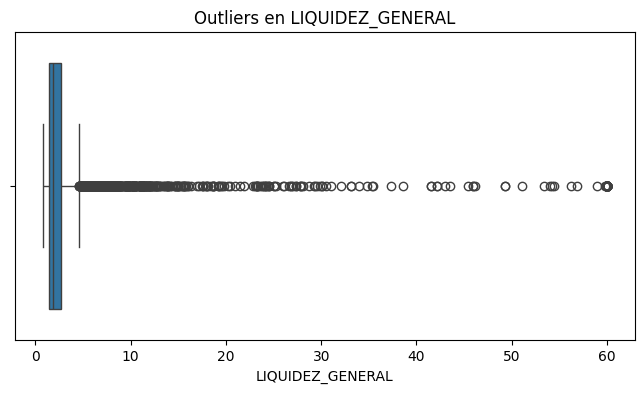

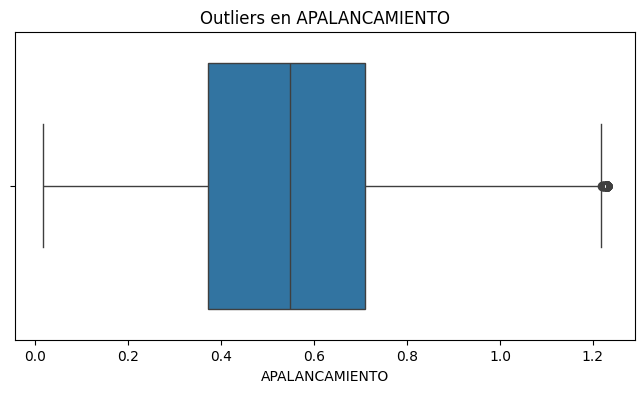

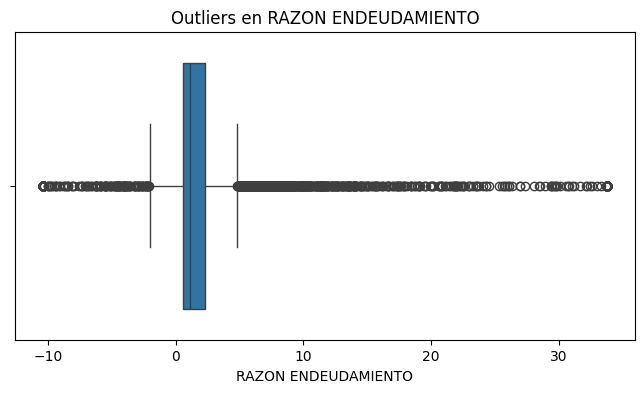

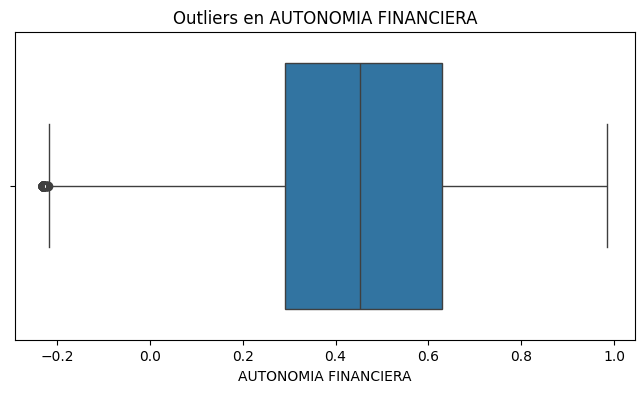

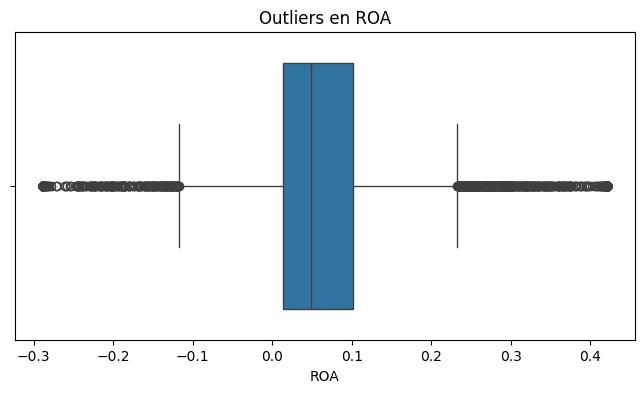

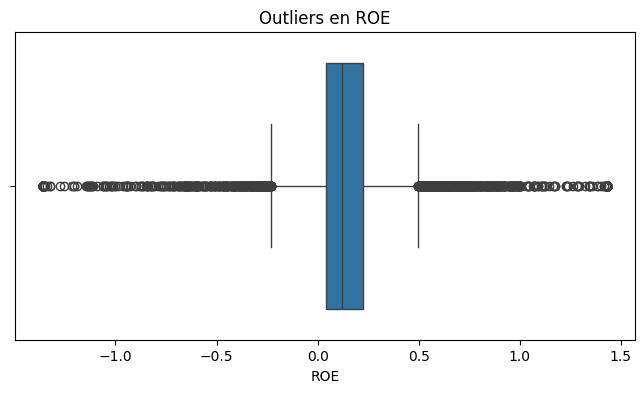

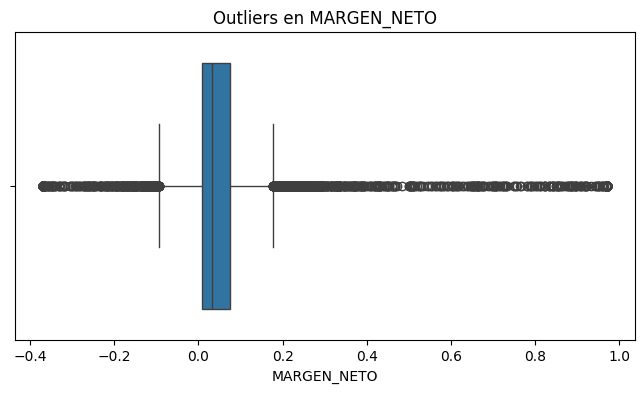

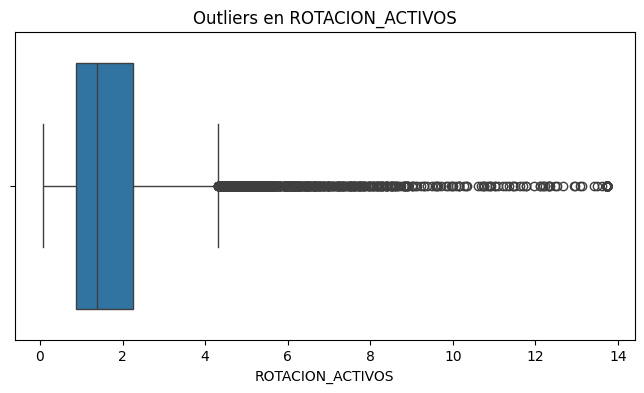

In [63]:
for col in indicadores:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df_empresas_2024[col])
    plt.title(f"Outliers en {col}")
    plt.show()

## Preprocesamiento

In [64]:
df_empresas_2024.dropna(inplace=True)
# Variables Numericas
X = df_empresas_2024[['INGRESOS OPERACIONALES 2024', 'GANANCIA (PERDIDA) 2024','LIQUIDEZ_GENERAL', 'APALANCAMIENTO', 'RAZON ENDEUDAMIENTO','AUTONOMIA FINANCIERA','ROA','ROE','MARGEN_NETO','ROTACION_ACTIVOS' ]]
X.dropna(inplace=True)
# Estandarizar Variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir a DataFrame para uso posterior
X_scaled_df = pd.DataFrame(X_scaled, columns=['INGRESOS OPERACIONALES 2024', 'GANANCIA (PERDIDA) 2024','LIQUIDEZ_GENERAL', 'APALANCAMIENTO', 'RAZON ENDEUDAMIENTO','AUTONOMIA FINANCIERA','ROA','ROE','MARGEN_NETO','ROTACION_ACTIVOS'])
X_scaled_df

/tmp/ipython-input-1151067968.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


,INGRESOS OPERACIONALES 2024,GANANCIA (PERDIDA) 2024,LIQUIDEZ_GENERAL,APALANCAMIENTO,RAZON ENDEUDAMIENTO,AUTONOMIA FINANCIERA,ROA,ROE,MARGEN_NETO,ROTACION_ACTIVOS
0,84.302,76.276,-0.236,0.267,-0.129,-0.267,0.087,0.122,0.436,-0.700
1,19.036,-1.406,0.015,-0.998,-0.369,0.998,-0.703,-0.487,-0.452,-0.638
2,18.214,2.650,-0.224,0.146,-0.168,-0.146,0.054,0.058,-0.253,0.586
3,15.118,24.605,-0.191,-0.122,-0.235,0.122,0.112,0.026,1.087,-0.812
4,14.276,1.845,-0.327,1.733,5.494,-1.733,-0.024,4.179,-0.267,0.571
...,...,...,...,...,...,...,...,...,...,...
9987,-0.116,-0.063,-0.007,-0.943,-0.363,0.943,-0.390,-0.344,-0.377,5.893
9988,-0.116,-0.060,-0.063,-0.766,-0.342,0.766,-0.151,-0.220,-0.218,-0.104
9989,-0.116,-0.059,-0.021,-0.902,-0.358,0.902,0.314,-0.015,-0.175,0.390
9990,-0.116,-0.075,-0.361,2.821,-1.154,-2.821,-1.296,0.014,-1.176,-0.711


In [65]:
## Determinar "K" Óptimo

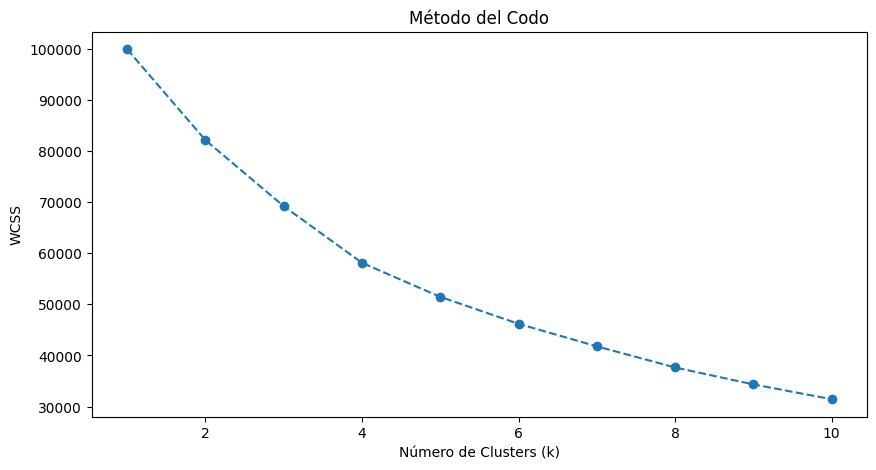

In [66]:
# Metodo del Codo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS')
plt.show()

Para n_clusters = 2, el coeficiente de silueta promedio es: 0.2530
Para n_clusters = 3, el coeficiente de silueta promedio es: 0.2535
Para n_clusters = 4, el coeficiente de silueta promedio es: 0.2704
Para n_clusters = 5, el coeficiente de silueta promedio es: 0.2715
Para n_clusters = 6, el coeficiente de silueta promedio es: 0.2887
Para n_clusters = 7, el coeficiente de silueta promedio es: 0.3001
Para n_clusters = 8, el coeficiente de silueta promedio es: 0.2823
Para n_clusters = 9, el coeficiente de silueta promedio es: 0.2826
Para n_clusters = 10, el coeficiente de silueta promedio es: 0.2905


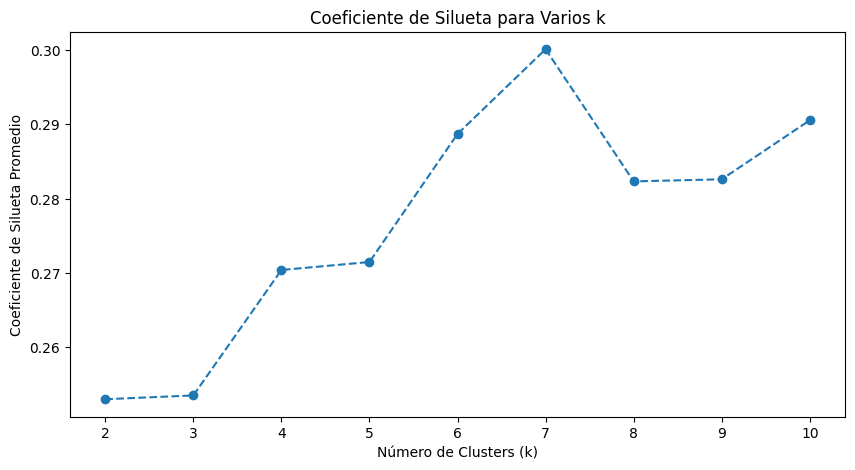

In [67]:
range_n_clusters = range(2, 11)

silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = clusterer.fit_predict(X_scaled_df)
    silhouette_avg = silhouette_score(X_scaled_df, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print(f"Para n_clusters = {n_clusters}, el coeficiente de silueta promedio es: {silhouette_avg:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o', linestyle='--')
plt.title('Coeficiente de Silueta para Varios k')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.show()

## K-Means

In [68]:
# Aplicar K-Means con k=7
kmeans = KMeans(n_clusters=7, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_scaled_df)

## Análisis Clusters

In [69]:
# Analizar Clusters
X['Cluster'] = clusters_kmeans
cluster_profile = X.groupby('Cluster').mean()
cluster_profile

/tmp/ipython-input-377827996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Cluster'] = clusters_kmeans


,INGRESOS OPERACIONALES 2024,GANANCIA (PERDIDA) 2024,LIQUIDEZ_GENERAL,APALANCAMIENTO,RAZON ENDEUDAMIENTO,AUTONOMIA FINANCIERA,ROA,ROE,MARGEN_NETO,ROTACION_ACTIVOS
Cluster,,,,,,,,,,
0,"135,390,082.115","17,874,901.302",3.718,0.343,0.591,0.657,0.111,0.187,0.108,1.553
1,"136,791,266.070","1,657,313.091",2.174,0.589,2.313,0.411,0.080,0.200,0.011,8.806
2,"179,670,164.355","162,602,499.678",48.583,0.027,0.022,0.973,0.183,0.247,0.742,0.855
3,"186,069,569.763","4,317,955.720",1.536,0.676,2.639,0.324,0.030,0.099,0.021,1.659
4,"113,923,310,323.000","14,934,704,562.000",1.641,0.609,1.560,0.391,0.070,0.178,0.131,0.532
5,"131,289,616.244","-35,567,720.403",0.880,1.143,-6.832,-0.143,-0.152,0.846,-0.163,1.620
6,"284,345,965.048","-18,449,449.200",1.068,0.940,21.359,0.060,-0.055,-0.411,-0.055,1.733


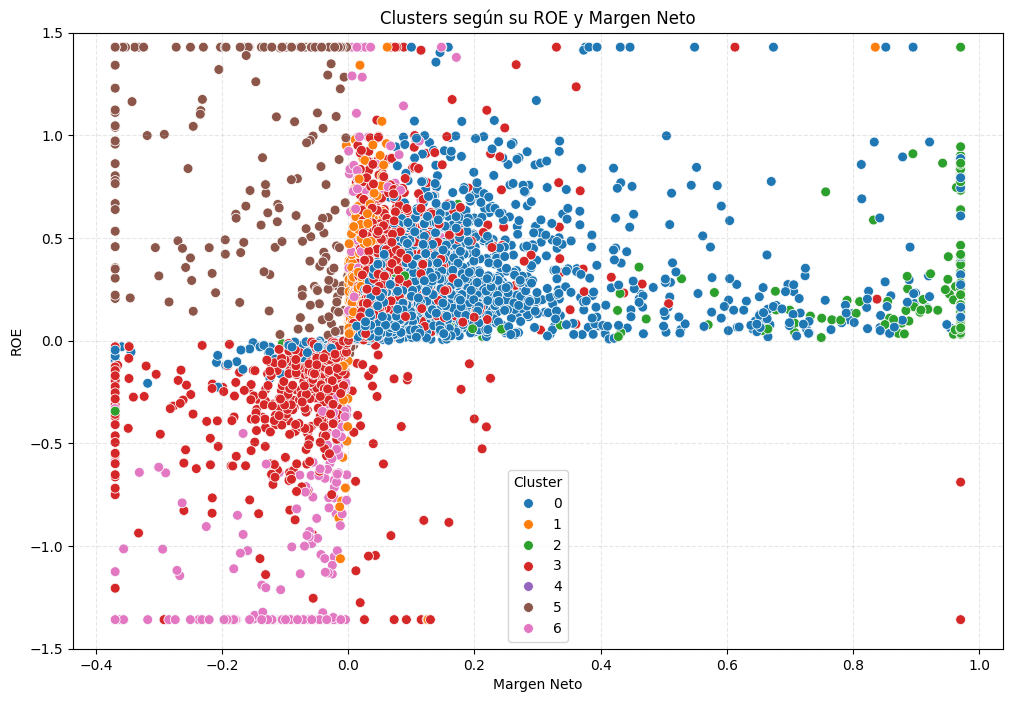

In [70]:
plt.figure(figsize=(12,8))
plt.scatter(X['MARGEN_NETO'], X['ROE'], c=X['Cluster'], alpha=0.6, cmap='tab10')

sns.scatterplot(
    data=X,
    x="MARGEN_NETO",
    y="ROE",
    hue="Cluster",
    palette="tab10",
    s=50
)

plt.title("Clusters según su ROE y Margen Neto")
plt.xlabel("Margen Neto")
plt.ylabel("ROE")
plt.ylim(-1.5, 1.5)

plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

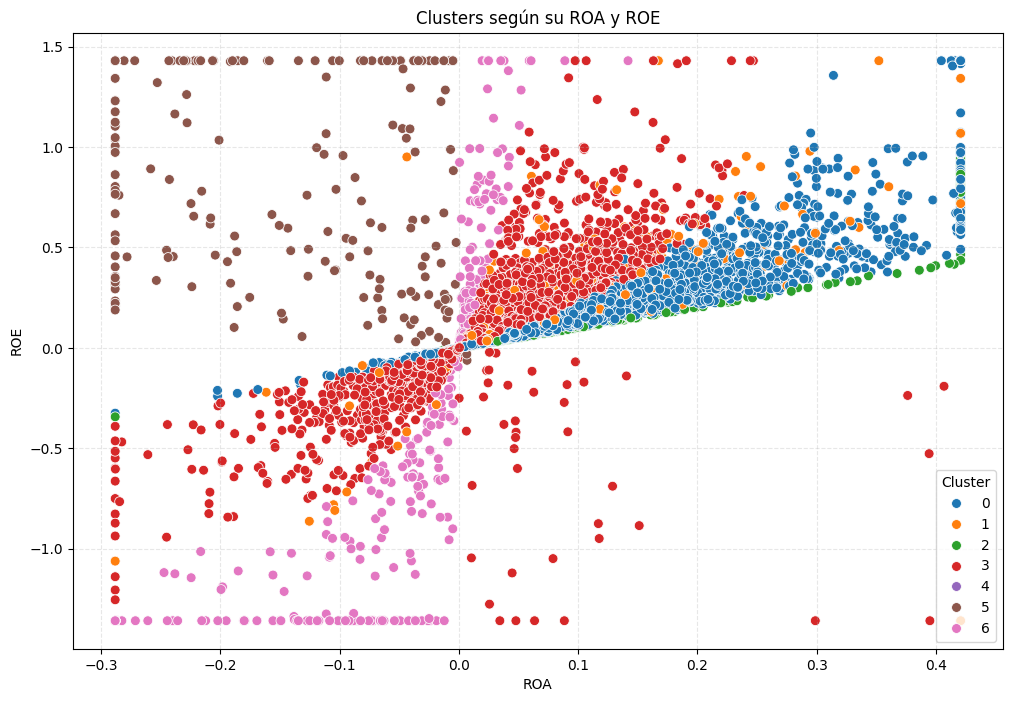

In [71]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=X, x="ROA", y="ROE",
                hue="Cluster", palette="tab10", s=50)
plt.title("Clusters según su ROA y ROE")
plt.xlabel("ROA")
plt.ylabel("ROE")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


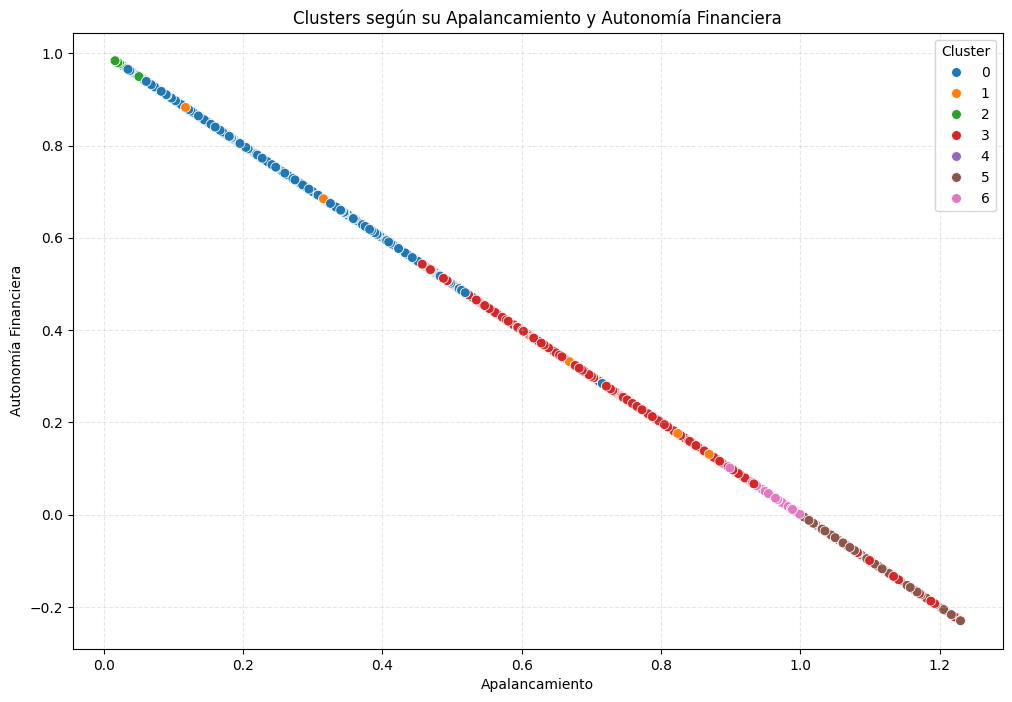

In [72]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=X, x="APALANCAMIENTO", y="AUTONOMIA FINANCIERA",
                hue="Cluster", palette="tab10", s=50)
plt.title("Clusters según su Apalancamiento y Autonomía Financiera")
plt.xlabel("Apalancamiento")
plt.ylabel("Autonomía Financiera")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


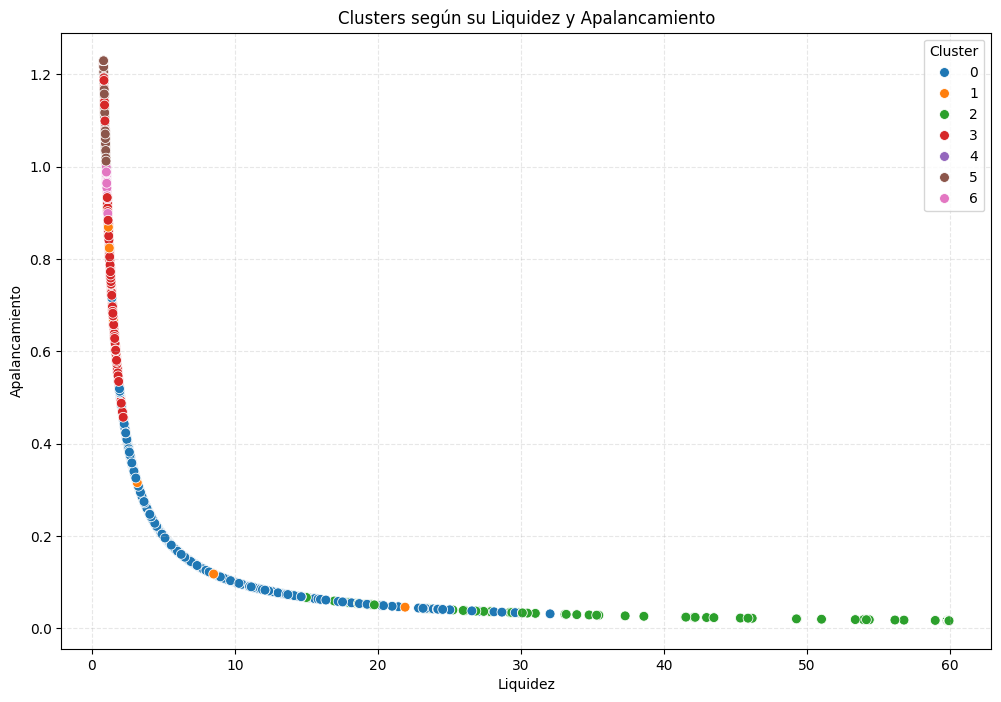

In [73]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=X, x="LIQUIDEZ_GENERAL", y="APALANCAMIENTO",
                hue="Cluster", palette="tab10", s=50)
plt.title("Clusters según su Liquidez y Apalancamiento")
plt.xlabel("Liquidez")
plt.ylabel("Apalancamiento")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()



## **Interpretación de Clusters: Perfiles de Riesgo y Solvencia**

A continuación, se presenta el perfilamiento de los 7 grupos identificados dentro de las 10,000 empresas más grandes de Colombia, clasificados según su comportamiento financiero y su probabilidad de entrar en insolvencia.

---

### **🔵 Cluster 0: Las "Empresas Modelo" (Equilibrio)**
* **Perfil:** Ingresos estables, alta liquidez (3.7) y rentabilidad sólida(18%). Representan a la empresa madura, bien administrada y con balances sanos.
* **Riesgo / Probabilidad de Insolvencia: MUY BAJA.**
    * Son las más seguras del mercado. Tienen un "colchón" financiero grande para soportar crisis, recesiones o caídas en ventas sin entrar en pánico.

---

### **🟠 Cluster 1: Los "Comerciantes de Volumen" (Retail/Mayoristas)**
* **Perfil:** Rotación de activos altísima (8.8x) pero márgenes de ganancia mínimos (1%). Viven del flujo constante de caja y no del margen por producto.
* **Riesgo / Probabilidad de Insolvencia: MODERADA.**
    * Su riesgo es puramente operativo. Si el consumo baja o la cadena de suministro falla, entran en pérdidas inmediatamente porque no tienen margen de error en sus precios

---

### **🟢 Cluster 2: Las "Cajas de Efectivo" (Holdings)**
* **Perfil:** Liquidez extrema (48.5) y casi cero deuda. Generalmente son holdings de inversión o empresas patrimoniales que reciben rentas y dividendos sin grandes costos operativos.
* **Riesgo / Probabilidad de Insolvencia: NULA.**
    * Son el grupo más seguro de todos. No tienen deudas que las presionen y tienen efectivo de sobra. Financieramente son "indestructibles" en el corto plazo.

---

### **🔴 Cluster 3: La "Industria Apretada" (Operativas)**
* **Perfil:** Márgenes bajos y apalancamiento medio-alto. Empresas que trabajan mucho para ganar poco y dependen del crédito para operar (Manufactura, Construcción).
* **Riesgo / Probabilidad de Insolvencia: MEDIA-ALTA.**
    * Están en la cuerda floja. Son muy sensibles a subidas de tasas de interés (porque deben dinero) o inflación de insumos. Un mal año económico podría obligarlas a reestructurar deudas.

---

### **🟣 Cluster 4: Los "Gigantes Corporativos"**
* **Perfil:** Ingresos billonarios y activos inmensos. Son las líderes absolutas del mercado (energía, infraestructura, grandes superficies) con estructuras pesadas.
* **Riesgo / Probabilidad de Insolvencia: BAJA.**
    * Aunque tienen deudas grandes, su tamaño y generación de caja les da acceso privilegiado a crédito. Son "demasiado grandes para caer" fácilmente, aunque su riesgo es sistémico.

---

### **🟤 Cluster 5: Las "Insolventes" (Quiebra Técnica)**
* **Perfil:** Patrimonio negativo y pérdidas operativas constantes. Deben más de lo que tienen (Apalancamiento > 1).
* **Riesgo / Probabilidad de Insolvencia: ESTADO CRÍTICO.**
    * Técnicamente ya están quebradas. Tienen el riesgo máximo: es muy probable que ya estén en procesos de reorganización o liquidación inminente si no reciben inyecciones de capital externo.

---

### **🌸 Cluster 6: Las "Empresas en Crisis"**
* **Perfil:** Destrucción masiva de valor (pérdidas grandes) y patrimonio a punto de desaparecer (apenas 6% de autonomía).
* **Riesgo / Probabilidad de Insolvencia: MUY ALTA.**
    * Están en "Cuidados Intensivos". Aún operan, pero están quemando sus últimos recursos. Tienen un riesgo inminente de *default* (no pago) a corto plazo si no cambian su modelo de negocio drásticamente.

In [74]:
from sklearn.preprocessing import MinMaxScaler

indicadores = {
    "Cluster": [0,1,2,3,4,5,6],
    "INGRESOS": [135390082.115,136791266.070,179670164.355,186069569.763,113923310323.000,131289616.244,284345965.048],
    "GANANCIA": [17874901.302,1657313.091,162602499.678,4317955.720,14934704562.000,-35567720.403,-18449449.200],
    "LIQUIDEZ": [3.718,2.174,48.583,1.536,1.641,0.880,1.068],
    "APALANCAMIENTO": [0.343,0.589,0.027,0.676,0.609,1.143,0.940],
    "ENDEUDAMIENTO": [0.591,2.313,0.022,2.639,1.560,-6.832,21.359],
    "AUTONOMIA": [0.657,0.411,0.973,0.324,0.391,-0.143,0.060],
    "ROA": [0.111,0.080,0.183,0.030,-0.070,-0.152,-0.055],
    "MARGEN": [0.108,0.011,0.742,0.021,0.131,-0.163,-0.055],
    "ROTACION": [1.553,8.806,0.855,1.659,0.532,1.620,1.733]
}

dfindicadores = pd.DataFrame(indicadores).set_index("Cluster")

df = dfindicadores.copy()

positivas = ["GANANCIA", "LIQUIDEZ", "AUTONOMIA", "ROA", "MARGEN"]

negativas = ["APALANCAMIENTO", "ENDEUDAMIENTO"]

scaler = MinMaxScaler()

df_norm = df.copy()
df_norm[positivas] = scaler.fit_transform(df[positivas])
df_norm[negativas] = scaler.fit_transform(df[negativas])

df_norm["risk_score"] = (
    (1 - df_norm[positivas]).sum(axis=1) +
    df_norm[negativas].sum(axis=1))

risk = df_norm["risk_score"].values.reshape(-1,1)
prob = MinMaxScaler().fit_transform(risk)

df["probabilidad_insolvencia"] = prob

df

,INGRESOS,GANANCIA,LIQUIDEZ,APALANCAMIENTO,ENDEUDAMIENTO,AUTONOMIA,ROA,MARGEN,ROTACION,probabilidad_insolvencia
Cluster,,,,,,,,,,
0,"135,390,082.115","17,874,901.302",3.718,0.343,0.591,0.657,0.111,0.108,1.553,0.491
1,"136,791,266.070","1,657,313.091",2.174,0.589,2.313,0.411,0.080,0.011,8.806,0.638
2,"179,670,164.355","162,602,499.678",48.583,0.027,0.022,0.973,0.183,0.742,0.855,0.000
3,"186,069,569.763","4,317,955.720",1.536,0.676,2.639,0.324,0.030,0.021,1.659,0.702
4,"113,923,310,323.000","14,934,704,562.000",1.641,0.609,1.560,0.391,-0.070,0.131,0.532,0.506
5,"131,289,616.244","-35,567,720.403",0.880,1.143,-6.832,-0.143,-0.152,-0.163,1.620,0.955
6,"284,345,965.048","-18,449,449.200",1.068,0.940,21.359,0.060,-0.055,-0.055,1.733,1.000


In [80]:

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

features_cluster = [
    "LIQUIDEZ_GENERAL",
    "APALANCAMIENTO",
    "RAZON ENDEUDAMIENTO",
    "AUTONOMIA FINANCIERA",
    "ROA",
    "ROE",
    "MARGEN_NETO",
    "ROTACION_ACTIVOS"
]

df_empresas_2024["Cluster"] = clusters_kmeans
X = df_empresas_2024[features_cluster]
y = df_empresas_2024["Cluster"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42)

rf = RandomForestClassifier(n_estimators=300, max_depth=None,
                            random_state=42, class_weight="balanced")

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

reporte = classification_report(y_test, y_pred, zero_division=1)
print(reporte)

joblib.dump(rf, "modelo_asignacion_cluster.pkl")

df_nuevas_empresas = pd.DataFrame({
    "LIQUIDEZ_GENERAL": [4.2],
    "APALANCAMIENTO": [6.1],
    "RAZON ENDEUDAMIENTO": [0.65],
    "AUTONOMIA FINANCIERA": [0.35],
    "ROA": [0.04],
    "ROE": [0.12],
    "MARGEN_NETO": [0.05],
    "ROTACION_ACTIVOS": [1.9]
})

rf = joblib.load("modelo_asignacion_cluster.pkl")

df_nuevas_empresas["Cluster_Predicho"] = rf.predict(df_nuevas_empresas)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       968
           1       0.97      0.93      0.95       114
           2       1.00      0.92      0.96        37
           3       0.99      0.99      0.99      1239
           4       1.00      0.00      0.00         1
           5       1.00      1.00      1.00        50
           6       0.98      0.94      0.96        89

    accuracy                           0.99      2498
   macro avg       0.99      0.83      0.83      2498
weighted avg       0.99      0.99      0.98      2498

